In [1]:
import os
import sys
import numpy as np
import torch
import logging

In [2]:
pkg_path = '/media/rajeev-gupta/Drive250/SENSYN_/from_sensyn_ws_src/GraphRCNN'
sys.path.insert(0, pkg_path)

In [3]:

from det3d import torchie
from det3d.torchie import Config
from det3d.datasets import build_dataset, build_dataloader
from det3d.models import build_detector
from det3d.torchie.apis import (
    get_root_logger,
    batch_processor
)
from det3d.torchie.trainer import get_dist_info, load_checkpoint
from det3d.torchie.trainer.utils import all_gather, synchronize
import pickle 
import time 

In [4]:
cfg_path = 'configs/waymo/voxelnet/two_stage/waymo_centerpoint_voxelnet_graphrcnn_6epoch_freeze_copy.py'

In [5]:
cfg = Config.fromfile(cfg_path)
cfg.local_rank = 0


In [6]:
logger = logging.getLogger()

In [7]:
model = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)


***************************model is build_from_cfg***************************
obj_type is str:  TwoStageDetector
[In build_from_cfg] building  <class 'det3d.models.detectors.two_stage.TwoStageDetector'>

***************************model is build_from_cfg***************************
obj_type is str:  VoxelNet
[In build_from_cfg] building  <class 'det3d.models.detectors.voxelnet.VoxelNet'>
Running super of VoxelNet (SingleStageDetector)

***************************model is build_from_cfg***************************
obj_type is str:  DynamicVoxelEncoder
[In build_from_cfg] building  <class 'det3d.models.readers.dynamic_voxel_encoder.DynamicVoxelEncoder'>

***************************model is build_from_cfg***************************
obj_type is str:  SpMiddleResNetFHD
[In build_from_cfg] building  <class 'det3d.models.backbones.scn.SpMiddleResNetFHD'>

***************************model is build_from_cfg***************************
obj_type is str:  RPN
[In build_from_cfg] building  <class 'de

In [8]:
device = torch.device('cpu')
map_location = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    map_location = 'cuda:0'

In [9]:
dataset = build_dataset(cfg.data.val)

obj_type is str:  WaymoDataset


KeyError: 'WaymoDataset is not in the dataset registry'

In [ ]:
len(dataset)

1

In [ ]:

data_loader = build_dataloader(
    dataset,
    batch_size=1,
    workers_per_gpu=cfg.data.workers_per_gpu,
    dist=False,
    shuffle=False,
)


In [ ]:
# for batch in data_loader:
#     b0 = batch
#     break

In [ ]:
# b0

In [ ]:
from tools import calibration_waymo
import cv2
import matplotlib.pyplot as plt


In [ ]:
data_path2 = '/media/rajeev-gupta/Drive250/SENSYN_/from_sensyn_ws_src/GraphRCNN/Ventoy/waymo_data/data/waymo/kitti2/raw_data/'
data_path = '/media/rajeev-gupta/Drive250/SENSYN_/from_sensyn_ws_src/GraphRCNN/Ventoy/waymo_data/data/waymo/kitti/raw_data/'
segment = 'segment-13145971249179441231_1640_000_1660_000_with_camera_label'
# segment = 'segment-13182548552824592684_4160_250_4180_250_with_camera_label'
index = 0
calib_path = os.path.join(data_path , segment, 'calib', f'{index:06d}.txt')
image_path = os.path.join(data_path , segment, 'image/FRONT', f'{index:06d}.png')
lidar_path = os.path.join(data_path, segment, 'velodyne', f'{index:06d}.bin')

In [ ]:

def get_calib_object(calib_path):
    calib = calibration_waymo.get_calib_from_file(calib_path)
    calib = calibration_waymo.Calibration(calib)
    return calib
# get_calib_object(calib_path)
def get_image(image_path):
    image = cv2.imread(image_path, cv2.COLOR_BGR2RGB).astype(np.float32)
    return image
# get_image(image_path)
def get_lidar(lidar_path):
    lidar = np.fromfile(lidar_path, dtype=np.float32).reshape(-1, 5)
    lidar[:, 3] = np.tanh(lidar[:, 3])
    return lidar
# get_lidar(lidar_path)
points=get_lidar(lidar_path)

In [ ]:
d0 = dataset.__getitem__(0, points)
d0

{'metadata': {'image_prefix': PosixPath('/media/rajeev-gupta/Drive250/SENSYN_/from_sensyn_ws_src/GraphRCNN/Ventoy/waymo_data/data/waymo'),
  'num_point_features': 5,
  'token': ''},
 'points': array([[-1.3595703e+01,  1.8554688e-02,  2.7539158e+00,  2.4675374e-01,
          0.0000000e+00],
        [-1.3589844e+01,  5.4321289e-02,  2.7536335e+00,  2.4675374e-01,
          0.0000000e+00],
        [-1.3589844e+01,  8.9843750e-02,  2.7535648e+00,  2.4675374e-01,
          0.0000000e+00],
        ...,
        [-2.9464691e+00, -3.8939266e+00,  1.4924914e-02,  1.4342278e-02,
          0.0000000e+00],
        [-1.8400444e+00, -4.0182409e+00,  3.1077772e-02,  1.1596160e-02,
          0.0000000e+00],
        [-2.3158829e+00, -3.8263392e+00,  2.1446764e-02,  2.6117107e-02,
          0.0000000e+00]], dtype=float32)}

In [ ]:
d0['points']

array([[-1.3595703e+01,  1.8554688e-02,  2.7539158e+00,  2.4675374e-01,
         0.0000000e+00],
       [-1.3589844e+01,  5.4321289e-02,  2.7536335e+00,  2.4675374e-01,
         0.0000000e+00],
       [-1.3589844e+01,  8.9843750e-02,  2.7535648e+00,  2.4675374e-01,
         0.0000000e+00],
       ...,
       [-2.9464691e+00, -3.8939266e+00,  1.4924914e-02,  1.4342278e-02,
         0.0000000e+00],
       [-1.8400444e+00, -4.0182409e+00,  3.1077772e-02,  1.1596160e-02,
         0.0000000e+00],
       [-2.3158829e+00, -3.8263392e+00,  2.1446764e-02,  2.6117107e-02,
         0.0000000e+00]], dtype=float32)

In [ ]:
d0['metadata'] = {'image_prefix': '', 'num_point_features': 5, 'token': ''}

In [ ]:
d0['points'] = [torch.Tensor(d0['points'])]
d0['metadata'] = [d0['metadata']]

In [ ]:
d0

{'metadata': [{'image_prefix': '', 'num_point_features': 5, 'token': ''}],
 'points': [tensor([[-1.3596e+01,  1.8555e-02,  2.7539e+00,  2.4675e-01,  0.0000e+00],
          [-1.3590e+01,  5.4321e-02,  2.7536e+00,  2.4675e-01,  0.0000e+00],
          [-1.3590e+01,  8.9844e-02,  2.7536e+00,  2.4675e-01,  0.0000e+00],
          ...,
          [-2.9465e+00, -3.8939e+00,  1.4925e-02,  1.4342e-02,  0.0000e+00],
          [-1.8400e+00, -4.0182e+00,  3.1078e-02,  1.1596e-02,  0.0000e+00],
          [-2.3159e+00, -3.8263e+00,  2.1447e-02,  2.6117e-02,  0.0000e+00]])]}

In [ ]:
ckpt = load_checkpoint(model, cfg.load_from, map_location, strict=False, logger=logger)

load_checkpoint
model loaded using LSD
model loaded with state dict


In [ ]:
model = model.cuda()
model.eval()
mode = "val"

In [ ]:
outputs = batch_processor(
                model, d0, train_mode=False, local_rank=cfg.local_rank,
            )

/media/rajeev-gupta/Drive250/conda_envs/new_graphrcnn/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180589158/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
outputs

[{'box3d_lidar': tensor([[ 10.7581,  -3.3755,   0.9071,   2.0056,   4.2026,   1.6772,  -1.5802],
          [ 18.8730,  -2.7505,   0.8448,   1.9819,   4.3861,   1.4951,  -1.6446],
          [  3.7086,  -3.3112,   0.8134,   1.9323,   4.2176,   1.5439,  -1.5655],
          [ 24.5634,   2.0084,   0.9794,   1.9483,   4.1265,   1.7294,  -2.1086],
          [  9.0865,   0.1709,   0.9662,   2.1213,   4.3905,   1.8077,  -1.5877],
          [ 25.0709,  -2.5764,   0.9462,   1.9785,   4.3687,   1.5682,  -1.6780],
          [ 28.5501,   1.1371,   1.0179,   1.9967,   4.3671,   1.7100,  -1.6819],
          [  0.9472,  -8.0335,   1.1914,   0.8558,   1.0505,   1.8360,   1.5938],
          [ 16.9008,   0.0829,   0.8369,   2.0684,   4.2243,   1.4376,  -1.6373],
          [ 15.9517, -10.1928,   1.2907,   0.8449,   1.1642,   1.8133,  -1.6969],
          [ 67.1422,   5.7148,   1.0577,   2.0403,   4.4339,   1.5904,  -1.6877],
          [ 31.9410,  -1.6649,   0.9184,   2.0580,   4.7862,   1.5216,  -1.6714],
 

In [ ]:
torch.cuda.empty_cache()
torch.cuda.synchronize()
del model
del d0

In [ ]:
del ckpt

In [ ]:
calib = get_calib_object(calib_path)

{'P0': array([[2.08032324e+03, 0.00000000e+00, 9.71168091e+02, 0.00000000e+00],
       [0.00000000e+00, 2.08032324e+03, 6.46494507e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]), 'Tr_velo_to_cam0': array([[ 2.22044605e-16, -1.00000000e+00, -0.00000000e+00,
        -2.38921549e-02],
       [ 2.22044605e-16,  4.93038066e-32, -1.00000000e+00,
         2.11608553e+00],
       [ 1.00000000e+00,  2.22044605e-16,  2.22044605e-16,
        -1.54428542e+00]]), 'P1': array([[2.07616455e+03, 0.00000000e+00, 1.00939062e+03, 0.00000000e+00],
       [0.00000000e+00, 2.07616455e+03, 6.22172852e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]), 'Tr_velo_to_cam1': array([[ 2.22044605e-16, -1.00000000e+00, -0.00000000e+00,
         9.47943404e-02],
       [ 2.22044605e-16,  4.93038066e-32, -1.00000000e+00,
         2.11572075e+00],
       [ 1.00000000e+00,  2.22044605e-16,  2.22044605e-16,
        -1.49726784e+

In [ ]:
image = get_image(image_path) / 255
image.shape

(1280, 1920, 3)

In [ ]:
pred_boxes = outputs[0]['box3d_lidar'].cpu().detach().numpy()
pred_boxes

array([[ 10.758054  ,  -3.3755133 ,   0.9071327 ,   2.0055623 ,
          4.202633  ,   1.6771623 ,  -1.580225  ],
       [ 18.872986  ,  -2.7505279 ,   0.8447578 ,   1.9818892 ,
          4.386053  ,   1.4950956 ,  -1.6446425 ],
       [  3.708557  ,  -3.311191  ,   0.8134091 ,   1.9322889 ,
          4.217642  ,   1.543883  ,  -1.5654702 ],
       [ 24.563353  ,   2.0084217 ,   0.9794494 ,   1.9483085 ,
          4.126498  ,   1.7294269 ,  -2.1086311 ],
       [  9.086457  ,   0.17090374,   0.9662195 ,   2.1213493 ,
          4.3905177 ,   1.8076645 ,  -1.5877101 ],
       [ 25.070896  ,  -2.5763671 ,   0.946248  ,   1.978497  ,
          4.368737  ,   1.56821   ,  -1.6779768 ],
       [ 28.550087  ,   1.1371176 ,   1.0178998 ,   1.9966527 ,
          4.3671026 ,   1.7100245 ,  -1.681924  ],
       [  0.9472207 ,  -8.033511  ,   1.1914462 ,   0.85582536,
          1.0505188 ,   1.8360051 ,   1.5938377 ],
       [ 16.900776  ,   0.08290504,   0.83689183,   2.0684118 ,
          4.2242

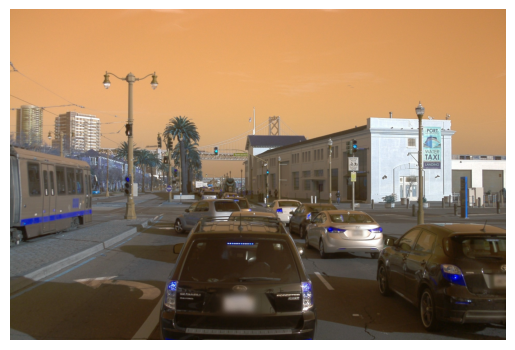

In [ ]:
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
cam_to_img = calib.P2
cam_to_img


array([[2.08032324e+03, 0.00000000e+00, 9.71168091e+02, 0.00000000e+00],
       [0.00000000e+00, 2.08032324e+03, 6.46494507e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [ ]:
def boxes3d_lidar_to_kitti_camera(boxes3d_lidar, calib):
    """
    :param boxes3d_lidar: (N, 7) [x, y, z, dx, dy, dz, heading], (x, y, z) is the box center
    :param calib:
    :return:
        boxes3d_camera: (N, 7) [x, y, z, l, h, w, r] in rect camera coords
    """
    import copy
    boxes3d_lidar_copy = copy.deepcopy(boxes3d_lidar)
    xyz_lidar = boxes3d_lidar_copy[:, 0:3]
    l, w, h = boxes3d_lidar_copy[:, 3:4], boxes3d_lidar_copy[:, 4:5], boxes3d_lidar_copy[:, 5:6]
    r = boxes3d_lidar_copy[:, 6:7]

    xyz_lidar[:, 2] -= h.reshape(-1) / 2
    xyz_cam = calib.lidar_to_rect(xyz_lidar)
    # xyz_cam[:, 1] += h.reshape(-1) / 2
    r = -r - np.pi / 2
    return np.concatenate([xyz_cam, l, h, w, r], axis=-1)


In [ ]:
# convert lidar boxes to camera frame
pred_boxes_cam = boxes3d_lidar_to_kitti_camera(pred_boxes, calib)
pred_boxes_cam[0]


array([3.35162116, 2.04753399, 9.21376836, 2.00556231, 1.67716229,
       4.2026329 , 0.00942862])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image_scope:  1280 1920
[-32156  22168]
[-32156  22917]
[-12980  -2738]
[-12980    634]
[-14837  -2800]
[-14837    634]
[-20691   4110]
[-20691    422]


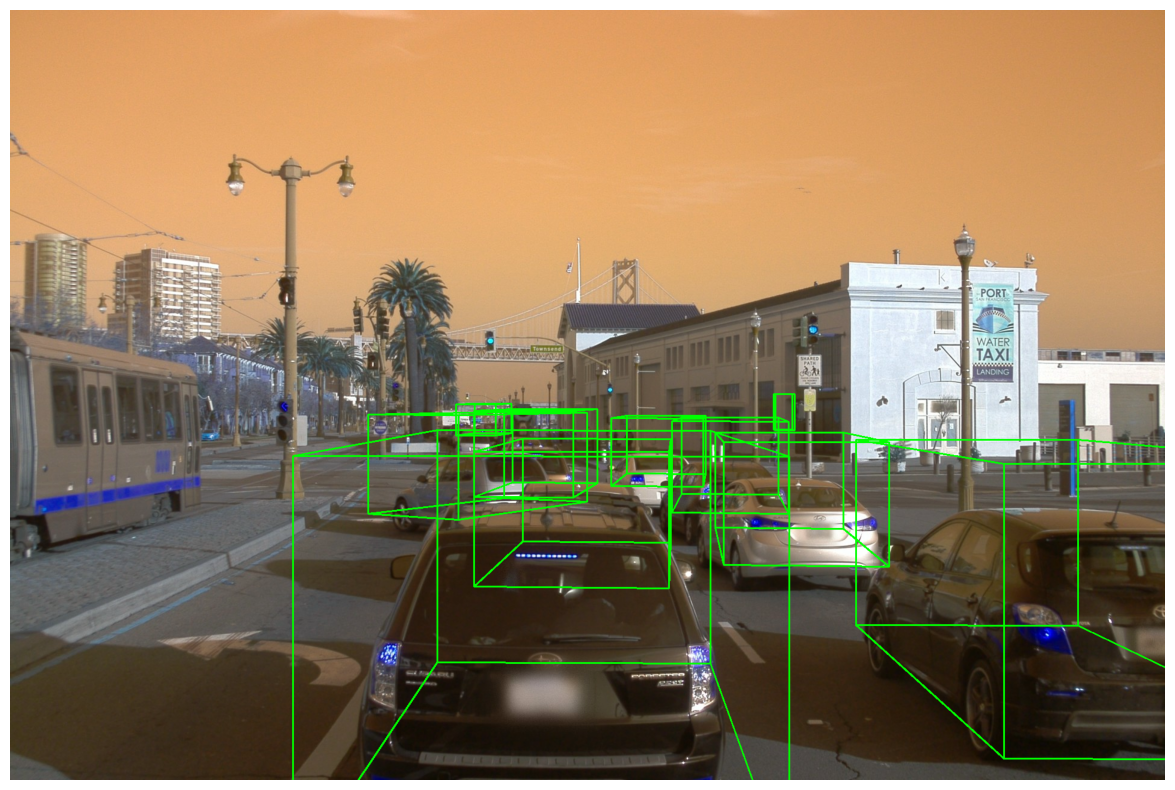

In [ ]:
# Draw 3D Bounding Box
import copy
image_with_boxes = copy.deepcopy(image)
scope_h, scope_k = image.shape[:2]
print('image_scope: ', scope_h, scope_k)
for line in pred_boxes_cam[:]:
# for line in [pred_boxes_cam[3]]:
    dims   = np.asarray([float(number) for number in line[3:6]])
    ## swap x, y, only required when reading from GD-MAE test - txt results
    tmp = dims[1]
    dims[1]=dims[0]
    dims[0]=tmp
    center = np.asarray([float(number) for number in line[0:3]])
    rot_y  = float(line[3]) + np.arctan(center[0]/center[2])
    rot_y  = float(line[3]) + float(line[6]) + np.arctan(center[0]/center[2])
    rot_y = float(line[6]) + 1.57
    # rot_y = 0
    box_3d = []
    is_bbox_inside_image_scope = True
    for i in [1,-1]:
        for j in [1,-1]:
            for k in [0,1]:
                point = np.copy(center)
                point[0] = center[0] + i * dims[1]/2 * np.cos(-rot_y+np.pi/2) + (j*i) * dims[2]/2 * np.cos(-rot_y)
                point[2] = center[2] + i * dims[1]/2 * np.sin(-rot_y+np.pi/2) + (j*i) * dims[2]/2 * np.sin(-rot_y)                  
                point[1] = center[1] - k * dims[0]
                point = np.append(point, 1)
                point = np.dot(cam_to_img, point)
                point = point[:2]/point[2]
                point = point.astype(np.int16)
                if  point[0]<0 or point[1]<0:
                    is_bbox_inside_image_scope = False
                    print(point)
                box_3d.append(point)
    if not is_bbox_inside_image_scope:
        continue
    for i in range(4):
        point_1_ = box_3d[2*i]
        point_2_ = box_3d[2*i+1]
        cv2.line(image_with_boxes, (point_1_[0], point_1_[1]), (point_2_[0], point_2_[1]), (0,255,0), 2)
    for i in range(8):
        point_1_ = box_3d[i]
        point_2_ = box_3d[(i+2)%8]
        cv2.line(image_with_boxes, (point_1_[0], point_1_[1]), (point_2_[0], point_2_[1]), (0,255,0), 2)

# Display the image using matplotlib
plt.figure(figsize=(20, 10))

plt.imshow(image_with_boxes)
plt.axis('off')  # Hide the axis
plt.show()